In [1]:
# Imports 
import os
import xml.etree.ElementTree as et
import pandas as pd
from itertools import chain

import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD as LSA
from sklearn.decomposition import LatentDirichletAllocation as LDA
import random
random.seed(13)


#visualisation stuff
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

import matplotlib
%matplotlib widget


In [2]:
# Load data 
PATH = "../xml/"
extension = ".xml"

def load_order(PATH, extension):
    """
    Custom function for loading and sorting the xml files from the TOTA dataset.
    Returns an array of filenames sorted by the number in the file name.
    """
    files = []
    for filename in os.listdir(PATH):
        if filename == ".ipynb_checkpoints":
            continue
        files.append(filename.split(".")[0]) # remove .xml
    files.sort(key=lambda x:int(x.split("_")[1])) # sort files based on file number 

    files = [file + extension for file in files]
#     print(files)
    return files

files = load_order(PATH, extension)

In [3]:
def xml2list(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """
    parsed_xml = et.parse(file)

    root = parsed_xml.getroot()

    meta_column_names = []
    meta_column_content = []

    for item in root[0]:
        grandchild = item.findall(".//")
        if grandchild:
            grandstore = []
            #print(item.tag)
            meta_column_names.append(item.tag)
            for x in grandchild:
                grandstore.append(int(x.attrib.get('n')))
                #print(x.tag +":", x.attrib)
            meta_column_content.append(grandstore)

        else:
            #print(item.tag +":", item.text)
            meta_column_names.append(item.tag)
            meta_column_content.append(item.text)
            
    return meta_column_names, meta_column_content
    
    
def xml2list_text(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """

    parsed_xml = et.parse(file)
    root = parsed_xml.getroot()
    chapters = []
    article_store = []
    
    treaty_text = ''
    
    for item in root[1]:
        chapter_name = item.attrib.get('name')
#         print("chapter: " + item.attrib.get('name'))
        chapters.append(chapter_name)
        if chapter_name == None:
            chapter_name = ''
        treaty_text += chapter_name + "\n"
        
        articles = item.findall("article")
        for article in articles:
#             print(article.attrib.get('name'))
            art_no = article.attrib.get('number')
            art_text =  article.text
            article_store.append(art_no)
            if art_no == None:
                art_no = ''
#             print(art_no)
            treaty_text += art_no + "\n"
            treaty_text += art_text + "\n"
        
            
    return len(chapters), len(article_store), treaty_text

In [4]:
def xml2list_chapters(file):
    parsed_xml = et.parse(PATH + file)
    root = parsed_xml.getroot()
    chapters = []
    article_store = []

    treaty_text = ''

    chapter_text_all = []
    chapter_type_all = []
    chapter_lan_all = []
    chapter_date_all = []
    chapter_region_all = []
    chapter_name_all = []
    
    type_agree = root[0].find('type')
    type_agree = type_agree.text
    
    name_agree = root[0].find('name')
    name_agree = name_agree.text
    
    region_agree = root[0].find('region')
    region_agree = region_agree.text
    
    lan_agree = root[0].find('language')
    lan_agree = lan_agree.text
    
    date_agree = root[0].find('date_into_force')
    if date_agree.text == None:
        date_agree = 1948
    else:
#     print(date_agree.text)
        date_agree = int(date_agree.text.split('-')[0])
    

    for item in root[1]:
        chapter_text = ''

        chapter_name = item.attrib.get('name')

        if chapter_name == None:
            chapter_name = ''

        chapters.append(chapter_name)

        chapter_text += chapter_name + "\n"

        articles = item.findall("article")
        for article in articles:
            art_no = article.attrib.get('number')
            art_text =  article.text
            chapter_text += art_text + "\n"

            if art_no == None:
                art_no = ''
            treaty_text += art_no + "\n"

        chapter_text_all.append(chapter_text)
        chapter_type_all.append(type_agree)
        chapter_lan_all.append(lan_agree)
        chapter_date_all.append(date_agree)
        chapter_region_all.append(region_agree)
        chapter_name_all.append(name_agree)

    return chapter_text_all, chapter_type_all, chapter_lan_all, chapter_date_all, chapter_region_all, chapter_name_all

In [5]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load('en')
tokenizer = Tokenizer(nlp.vocab)

In [6]:
textdf = pd.DataFrame()

treaty_text = []
treaty_types = []
treaty_language = []
treaty_date = []
treaty_region = []
treaty_name = []

for i in range(0, len(files)):
    chapters, types, language, date, region, name = xml2list_chapters(PATH + files[i])
    treaty_text.extend(chapters)
    treaty_types.extend(types)
    treaty_language.extend(language)
    treaty_date.extend(date)
    treaty_region.extend(region)
    treaty_name.extend(name)
    
t_txt = []
for doc in tokenizer.pipe(treaty_text, batch_size=50):
    t_txt.append(doc.text.lower())

textdf["chapter_text"] = t_txt
textdf["type"] = treaty_types
textdf["language"] = treaty_language
textdf["year"] = treaty_date
textdf["region"] = treaty_region
textdf["name"] = treaty_name

In [7]:
textdf = textdf[textdf.language == 'en']
textdf = textdf.reset_index()
textdf.head()

,index,chapter_text,type,language,year,region,name
0,0,preamble\npreamble japan and the kingdom of t...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand
1,1,general provisions\nthe objectives of this agr...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand
2,2,trade in goods\nfor the purposes of this chapt...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand
3,3,rules of origin\nfor the purposes of this chap...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand
4,4,customs procedures\n1. this chapter shall appl...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand


In [8]:
# x= list(textdf.year)
# n_i = []
# for i in x:
#     i = (i - min(x)) / (max(x) - min(x))
#     n_i.append(i)
# n_i
# textdf["opacity"] = n_i

In [9]:
chapter_name = []
for i in range(0,len(textdf['chapter_text'])):
    chapter_name.append(textdf['chapter_text'][i].split('\n')[0])
textdf['chapter_title'] = chapter_name

In [10]:
textdf.head()

,index,chapter_text,type,language,year,region,name,chapter_title
0,0,preamble\npreamble japan and the kingdom of t...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand,preamble
1,1,general provisions\nthe objectives of this agr...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand,general provisions
2,2,trade in goods\nfor the purposes of this chapt...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand,trade in goods
3,3,rules of origin\nfor the purposes of this chap...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand,rules of origin
4,4,customs procedures\n1. this chapter shall appl...,Free Trade Agreement & Economic Integration Ag...,en,2007,East Asia,Japan - Thailand,customs procedures


In [11]:
# dfcols, null = xml2list(PATH + files[3])
# totadf = pd.DataFrame(columns=dfcols)

# for i in range(0, len(files)):
#     dfcolstmp, datatmp = xml2list(PATH + files[i])
#     tmp_df = pd.DataFrame([datatmp], columns=dfcolstmp)
#     tmp_df = tmp_df.loc[:,~tmp_df.columns.duplicated()] #very important! removes duplicate columns note that it removes the multiple "source" columnsns
#     totadf = totadf.loc[:,~totadf.columns.duplicated()]#very important! removes duplicate columns note that it removes the multiple "source" columnsns 
#     totadf = pd.concat([totadf,tmp_df], axis=0, sort=False)
# totadf = totadf.reset_index(drop=True)
# totadf = pd.concat([totadf, textdf], axis=1)

In [12]:
# totadf.head()

In [24]:
# totadf['year_signed'] = totadf.date_signed.map( lambda x: pd.to_datetime(x).year)
# totadf = totadf[totadf.language == 'en']
# totadf['language'].unique()
# new = ['treaty_identifier', 'chapter_text', 'year_signed', 'type']
# totadf_emb = totadf[new]
# totadf_emb = totadf_emb.reset_index()
# totadf_emb.head()

In [13]:
# with open('alltext.txt', 'w') as f:
#     for item in t_txt:
#         f.write("%s\n" % item)

In [14]:
from collections import Counter

with open("alltext.txt") as f:
    wordcount = Counter(f.read().split())
print(len(wordcount)) 
stop_words_law = []
for item, frequency in wordcount.most_common(2000):
    stop_words_law.append(item)
stop_words_law.append('\n')

89133


In [33]:
# Parameters that I tweaked - could probably spend a whole week trying to find the best combination - but this selection seems to work just fine
# for number in range(20,150,10):
n_features = 1000
n_topics =  10 #because I want it to try and cluster based on the 5 treaty types
n_top_words = 10


# text_data = totadf_emb[totadf_emb.type == "Free Trade Agreement & Economic Integration Agreement"]

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
#I convert a collection of raw documents into a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features, stop_words=stop_words_law)
#retearns a term-document matrix
tfidf = tfidf_vectorizer.fit_transform(textdf['chapter_text'])
# This is where the non negative matrix factorization happens - in short it is a form of dimensionality reduction
nmf = LDA(n_components=n_topics).fit(tfidf)

print("Topics found via NMF:")
# need to print the words most related to the seperate topics - quite difficult to differentiate by hand. 
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

nmf_embedding = nmf.transform(tfidf)

threshold = 0.3
_idx = np.amax(nmf_embedding, axis=1) > threshold  # idx of doc that above the threshold
nmf_embedding = nmf_embedding[_idx]
# nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)
# topics = list(range(n_topics)) #these are hand coded topics and probably do not represent the actual topics 

top_idx = np.argsort(nmf_embedding, axis=0)[-3:]

count = 0
for idxs in top_idx.T:
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(textdf.iloc[idx][['name', 'region', 'type']])
    count += 1

tsne = TSNE(random_state=3211, perplexity=30, learning_rate=100) # run t-sne with the various parameters
tsne_embedding = tsne.fit_transform(nmf_embedding) 
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y']) # turn the results into a dataframe
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1) # attach a hue column so that we can later color each cluster differently
tsne_embedding['year'] = textdf['year'] # attach a year column so that we can see the evolution of the treaties over time. 
tsne_embedding['type'] = textdf['type']
tsne_embedding['name'] = textdf['name']
tsne_embedding['region'] = textdf['region']
# tsne_embedding['opacity'] = textdf['opacity']
tsne_embedding['chapter_name'] = textdf['chapter_title']



/Users/ollieford/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topics found via NMF:

Topic #0:
anti initiation mfn eaeu sacu adjustment absolute mutandis lesser africa

Topic #1:
unions co forthwith weapons justify re non repayment tasks artistic

Topic #2:
ukraine non territorial canada tools heading seabed hs containers accessories

Topic #3:
fishery veterinary pursuance xx non discriminatory find xiv possibilities users

Topic #4:
non sub border cross certainty immigration anti conforming secretary nationality

Topic #5:
witness whereof undersigned authentic texts languages russian depositary text thereto

Topic #6:
co hereinafter follows economies growth partnership georgia people approximation europe

Topic #7:
committees initiated positions draft complaint questions mediation offices non arguments

Topic #8:
xxiv moldova bulgaria serbia erga hand replace albania estonia herzegovina

Topic #9:
slovenia hungary poland accreditation lithuania clearance sub latvia non administrations


Topic 0:
name          Turkey - Albania
region             

In [164]:
# plt.savefig(f'ToTa_Chapters_20_.png', format='png', dpi=200)

<Figure size 432x288 with 0 Axes>

In [29]:
tsne_embedding['type'].unique()

array(['Free Trade Agreement & Economic Integration Agreement',
       'Free Trade Agreement', 'Customs Union',
       'Customs Union & Economic Integration Agreement',
       'Partial Scope Agreement', 'Economic Integration Agreement'],
      dtype=object)

In [32]:
tsne_embedding.to_csv("Chap_clust.csv")

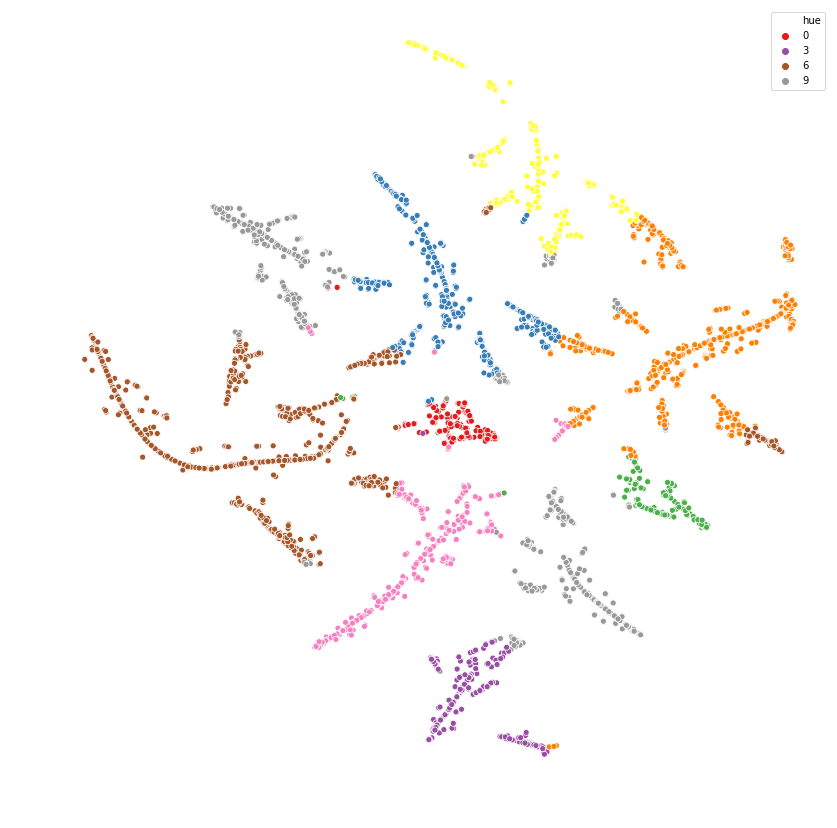

In [35]:
# color_list = plt.cm.tab20(np.linspace(0, 1, len(textdf.type.unique())))


# color = [r,g,b, a]
legend_list = []

# for i in range(len(topics)):   
#     color = color_list[i]
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))


fig, axs = plt.subplots(figsize=(14, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)
data=tsne_embedding

# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']+.02, point['y'], str(point['val']))

# label_point(data.x, data.y, data.year, plt.gca())

scatter = sns.scatterplot(data=data, x='x',y='y', hue='hue', palette='Set1')
# axs.set_title('Treaties signed until {}'.format(year),**{'fontsize':'10'})
axs.axis('off')

#     fig.legend(legend_list, topics, loc=(0.2,0.89), ncol=5)
plt.subplots_adjust(top=0.85)

# plt.savefig('LDA_40_CHA_TYP.svg', format='svg', dpi=100, transparent=True)